<h2>ASSIGNMENT 5: Airline reviews classification with bidirectional GRU<h2>

<h4><b>Author</b>: Aliprandi Francesco<h4>


<b>NOTA:</b> the execution of this notebook has been parameterized to run both locally and on colab. Initially, the notebook was run locally but, for efficiency reasons, with larger models, colab's GPU runtime was exploited.

In [1]:
#necessary for execution on colab
! pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.1 MB/s eta 0:00:00


<h4><b>LIBRARIES AND GLOBAL VARIABLES </b></h4>

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import contractions

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras as K
from keras import Input
from keras import regularizers
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Bidirectional, GRU
from keras.callbacks import EarlyStopping
from keras.metrics import F1Score

colab_execution = True

embedding_dim = 300  # Define the embedding dimension
glove_embedding = "glove.6B." + str(embedding_dim) +"d.txt"

if colab_execution:
  nltk.download('punkt')
  !gdown 1F9Gg-qd5Q9j3fH6_JzuBnykF63QrYCVp
  if(embedding_dim == 300):
    !gdown 1QyW2tz3_VjxK0nzE2bu5CnTxSYyhKY64
  if(embedding_dim == 200):
    !gdown 1GlmdQzXhhBgBbNYx16mR2pXs2onmUVev
  if(embedding_dim == 100):
    !gdown 198jMHeVa76LP2naEUs7RAKuvHaZzKUBa

  EMBEDDINGS_PATH = "/content/" + glove_embedding
  DATASET_PATH = "/content/Airline_Reviews.csv"
else:
  PROJECT_FOLDER_PATH =  os.path.dirname(os.path.abspath(os.getcwd()))
  DATASET_PATH = os.path.join(PROJECT_FOLDER_PATH, "dataset", 'Airline_Reviews.csv')
  EMBEDDINGS_PATH = os.path.join(PROJECT_FOLDER_PATH, "dataset", glove_embedding)
  #google_embeddings = KeyedVectors.load_word2vec_format(EMBEDDINGS_PATH+'/GoogleNews-vectors-negative300.bin', binary=True) #download google pretrained embeddings


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

glove_embeddings = {}
with open(EMBEDDINGS_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

vocab_size = 20000  # Define the vocabulary size
max_sequence_length = 200  # Define the maximum sequence length
num_classes = 9  # Define the number of output classes

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading...
From: https://drive.google.com/uc?id=1F9Gg-qd5Q9j3fH6_JzuBnykF63QrYCVp
To: /content/Airline_Reviews.csv
100% 20.5M/20.5M [00:00<00:00, 143MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QyW2tz3_VjxK0nzE2bu5CnTxSYyhKY64
From (redirected): https://drive.google.com/uc?id=1QyW2tz3_VjxK0nzE2bu5CnTxSYyhKY64&confirm=t&uuid=5a320196-12ef-48c1-8204-734ca000658b
To: /content/glove.6B.300d.txt
100% 1.04G/1.04G [00:12<00:00, 83.0MB/s]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h4><b>1. DATASET MANAGEMENT </b></h4>




<h4><b>1.1 Read dataset </b></h4>




<b>read_data</b>: this function allows to read the relevant columns in the dataset. 
To improve model's prediciting capabilities both title and review are considered by concatenating them in a single sentence.

In [4]:
def read_data(file_path):
    """
    Read the dataset from the file path.
    :param file_path: The path to the dataset.
    :return: The dataset and the targets as a pandas DataFrame
    """
    df = pd.read_csv(file_path)[["Review_Title", "Review", "Overall_Rating"]]
    df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], errors='coerce')
    df["Review_Title"] = df['Review_Title'].str.strip('"')
    df ["Review"] = df["Review_Title"] + " " + df["Review"]
    df.dropna(subset=['Overall_Rating'], inplace=True)
    df = df.drop(columns=["Review_Title"])
    return df

df = read_data(DATASET_PATH)

<h4><b>1.1.2 Dataset analysis</b></h4>

In this cell three random reviews are selected from class 1, 4 and 9.
These randomly extracted examples from the dataset reveal the presence of outliers, which significantly complicate the classification problem. Despite belonging to completely different classes, all these reviews seems to be very positive.

In [ ]:
random_rows = df.groupby('Overall_Rating').apply(lambda x: x.sample(1))

# Stampa le righe selezionate casualmente
for index, row in random_rows.iterrows():
    if row['Overall_Rating'] in [1,4,9]:
        print(f"Classe: {row['Overall_Rating']}\nReview: {textwrap.fill(row['Review'],100)}\n")


Classe: 1.0
Review: a very good flight   Las Vegas to Manchester. My first time flying with Thomas Cook Airlines it was
a very good flight. The crew was very polite and charismatic and made sure all my needs where met.
One of the flight attendants even gave me a IFE Code free since my debit card wouldn't work with
their machines. I flew economy and had good leg room but my knees constantly hit the tray table when
I had to move. This was annoying but I only ran into the problem during meal service. The plane
arrived on time.  The plane had no on-board WIFI but I was asleep for most of the flight so that
wasn't to much of a problem. The A330-200 didn't have personal air-vents.

Classe: 4.0
Review: Air Nostrum customer review Gran Canaria - Valencia return. Checked in online in both directions and
only had to drop my luggage at the counter. Almost full CRJ 200 and must admit that it was a
pleasure to fly with this airline. Comfortable leather seats emergency exit seat so plenty of
legroom

The dataset is highly skewed in favor of class 1, further complicating the analysis

In [ ]:
df['Overall_Rating'].value_counts()

Overall_Rating
1.0    11595
2.0     2296
9.0     1768
8.0     1757
3.0     1356
7.0     1192
4.0      859
5.0      830
6.0      676
Name: count, dtype: int64

<h4><b>1.2 Preprocessing </b></h4>

<b>Create embedding matrix:</b>

this function create the embedding matrix using pretrained embeddings. It also compute the ratio between founded and unfounded tokens inside the text and stores unfounded tokens in a list. 

For this analysis pretrained embeddings are selected to significantly reduce the total number of parameters to be trained. 

Four different pretrained embeddings were considered: Google news pretrained embeddings and Glove pretrained embedding with size 100, 200, 300. Glove embeddings were preferred to Google embeddings because they allowed for a higher matching rate while the size of the embeddings was chosen based on the results in validation obtained on the model.

<b>Remove contraction:</b> function that remove contracted forms from sentences. It allows maximizing the tokens recognized among those in the glove vocabulary tokens.

<b>Stopword removal</b> function that remove stopwords forms from sentences. It allows to improve model generalization by remove frequent, non-discriminative words

<b>Data preprocessing:</b> perform the preprocessing on the dataset:
1. lowercase sentences
2. remove contractions
3. remove everything that is not alphanumeric using regex
4. tokenize the sentece
5. remove stopwords
6. transform text in numeric sequence
7. pad sequence
8. one-hot encode target column

In [5]:
def create_embedding_matrix(word_index, pretrained_embeddings):
    """
    Create the embedding matrix from the word embeddings.
    :param word_index: The word index.
    :param pretrained_embeddings: The pretrained embeddings.
    :return: The embedding matrix.
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    find = 0
    not_find = 0
    unmached_words = []
    for word, i in word_index.items():
        if word in pretrained_embeddings:
            embedding_vector = pretrained_embeddings[word]
            embedding_matrix[i] = embedding_vector
            find += 1
        else:
            embedding_matrix[i] = np.random.normal(0, 1, embedding_dim)
            not_find += 1
            if word not in unmached_words:
                unmached_words.append(word)
    return embedding_matrix, find/(find+not_find), unmached_words

def remove_contraction(sentence):
    """
    Remove contracted form from sentence

    :param corpus: the sentence to remove contractions from
    :return: the cleaned sentence
    """
    expanded_words = []
    for word in sentence.split():
        expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)

def stopwords_removal(sentence):
    """
    Remove the stop words from the text.

    :param corpus: The text to remove the stop words from
    :return: The text with the stop words removed, as a string.
    """
    filtered_sentence = []
    for w in sentence:
        if w not in stop_words:
            filtered_sentence.append(w)
    return list(filtered_sentence)

def data_preprocessing(df):
    """
    Clean the text by removing stopwords and punctuation.
    :param df: The df to clean
    :return: The cleaned df as a list of sentences , the targets hone hot encoded and the word index
    """
    #drop rows to balance dataset
    #df.drop(df[df['Overall_Rating'] == 1.0].sample(frac=0.7).index, inplace=True)
    #lower case sentences
    df["Review"] = df["Review"].str.lower()
    #remove contractions
    df['Review'] = df['Review'].apply(remove_contraction)
    #remove non alphanumeric characters (also puntation)
    df["Review"] = df["Review"].replace(r'[^a-zA-Z0-9\s]', '', regex=True)
    #tokenize sentences
    df['Review'] = df['Review'].apply(word_tokenize)
    #remove stopwords
    df['Review'] = df['Review'].apply(stopwords_removal)
    #convert to list
    corpus = df["Review"].values.tolist()
    #text to sequence
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(corpus)
    word_index = tokenizer.word_index
    #print("Found", len(word_index), "unique tokens.")
    corpus = tokenizer.texts_to_sequences(corpus)
    #pad sequences
    corpus = pad_sequences(corpus, maxlen=max_sequence_length)
    #one hot encode targets
    target = pd.get_dummies(df["Overall_Rating"], dtype=float)
    target = np.array(target.values.tolist())
    return corpus, target, word_index

inputs, targets, word_index = data_preprocessing(df)
print(word_index)
#keep only the first vocab_size words
word_index = dict(list(word_index.items())[:vocab_size-1])

embedding_matrix, find_ratio, unmached_words = create_embedding_matrix(word_index, glove_embeddings)

This cell shows find ratio inside the glove pretrained embeddings. 87% of the tokens in the dataset were recognized within Glove's vocabulary. Among the 2,639 unrecognized tokens, we can observe typos, numbers, nonsense words, as well as meaningful words that likely fall outside the domain covered by GloVe. In the create_embedding_matrix function, the embeddings for these tokens are replaced with random noise generated from a Gaussian distribution.

In [ ]:
import random

print("Find ratio:", find_ratio)
print("Unmached tokens count:", len(unmached_words))
print("Unmached words examples:\n" + str(random.sample(unmached_words, 10)))
print(str(random.sample(unmached_words, 10)))

Find ratio: 0.8680434021701086
Unmached tokens count: 2639
Unmached words examples:
['442316', 'beenruimte', 'wellorganized', 'fukkix', 'cous', '7378', 'jt25', 'moodlighting', 'luxfra', 'b767']
['noshow', 'queing', 'groundforce', 'galement', 'innan', 'bwn', 'unrespectful', 'bezahlen', 'ancfaianc', 'overpacked']


Since the problem is highly unbalanced, train test split is applied applying stratify technique. Manually random undersampling was considered to try to handle the unbalanced dataset. However, this technique only reduced the predictive ability of the models.

In [6]:
x_train, x_temp, y_train, y_temp = train_test_split(inputs, targets, test_size=0.4, stratify=targets, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=10)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(13397, 200) (13397, 9) (4466, 200) (4466, 9) (4466, 200) (4466, 9)


<h4><b>1.3 Model architecture and training</b></h4>

The best architecture for the model was found by performing a manual grid search on several possible architectures for efficiency reasons. A grid search on such large models would have required too much computing power for the free colab plan. However, by running on colab's GPU, it was possible to use slightly larger architectures.

<b>Architecurals choices:</b>
- <b>Pretrained embeddings</b>: the use of pretrained embeddings allowed the number of trainable parameters of the model to be reduced from 6M to about 200k. This reduction resulted in an improvement in the average performance of the model and, more importantly, allowed the use of slightly larger regularized architectures.
- <b>GRU</b>: The use of Gated Recurrent Units (GRUs) results in a model with higher storage capacity than a simple RNN and fewer parameters than an LSTM model.
- <b>Bidirectional</b>: the use of bidirectional layers allows to process the input sequence both from left to right and from right to left, to make the most of the input data. The use of bidirectional layer is always recomanded when all the input sequence is known.
- <b>dense NN</b>: a dense NN is added at the end of the model to best postprocess the information extracted from the two GRU layers. The softmax function allows a probability distribution to be obtained in output.
- <b>F1-score</b>: F1 score is considered instead of accuracy given the unbalancing of the dataset. 
- For managing dataset unbalancing also a weighted personalized loss was considered but it led to worse results.

<b>Model training</b>: 

for model training, the number of epochs was set at 12 to avoid overfitting and the batch size at 64 because it often represents a good compromise between gradient stability and training speed. As it is possible to observe early stopping is triggered to prevent overfitting. 

In [47]:
model = Sequential()
# Add an input layer
model.add(Input(shape=(None,), dtype="int32"))
# Add an embedding layer to convert input sequences to dense vectors
model.add(Embedding(input_dim=vocab_size,  output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
# Add LSTM layers
model.add(Bidirectional(GRU(70, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(GRU(35, dropout=0.3, return_sequences=False)))
# add a NN for 9 class classification
model.add(Dense(36, activation='relu', kernel_regularizer=regularizers.L2(1e-5)))
model.add(Dropout(0.4, noise_shape=None, seed=10))
model.add(Dense(18, activation='relu', kernel_regularizer=regularizers.L2(1e-5)))
model.add(Dense(9, activation='softmax'))

# Compile the model
f1 = F1Score(average="weighted", name="f1_score")
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[f1])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.007, patience=2)

history = model.fit(x_train, y_train, epochs=12, batch_size=64, validation_data=(x_val,y_val), callbacks=[early_stopping])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 300)         6000000   
                                                                 
 bidirectional_26 (Bidirect  (None, None, 140)         156240    
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 70)                37170     
 ional)                                                          
                                                                 
 dense_39 (Dense)            (None, 36)                2556      
                                                                 
 dropout_13 (Dropout)        (None, 36)                0         
                                                                 
 dense_40 (Dense)            (None, 18)              

<h4><b>1.3 Model evaluation</b></h4>

The value of the model loss is in line with that of the validation loss, highlighting the effectiveness of early stopping in preventing overfitting. In addition, the plot of the training and validation curves demonstrates the stability and smoothness of the training process.

The value of the F1-score is insignificant given the countless challenges encountered in managing that dataset such as: the unbalance of the dataset, the presence of outliers and the high number of classes. 

140/140 [==============================] - 3s 20ms/step - loss: 1.2627 - f1_score: 0.4868
Test set:
  Loss: 1.263
  Weighted F1-score: 0.487


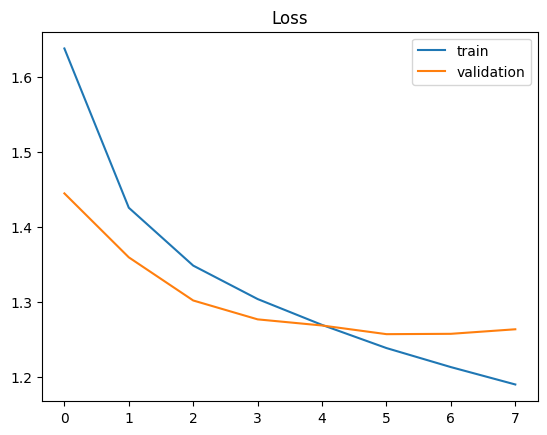

In [48]:
y_pred = model.predict(x_test)

# Evaluate the model
loss, f1 = model.evaluate(x_test, y_test)
print('Test set:\n  Loss: {:0.3f}\n  Weighted F1-score: {:0.3f}'.format(loss, f1))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

To measure the predictive ability of the model, the average distance between the class predicted by the model and the true label was calculated. The model is very unbalanced in recognizing classes 1 and 8 (probable "centroids" for subclasses such as "very bad trip" and "very good trip"), being poor at recognizing intermediate classes.


In [49]:
y_pred_cat = np.argmax(y_pred, axis=1)+1
y_test_cat = np.argmax(y_test, axis=1)+1
distance = 0

for i in range(len(y_pred_cat)):
    distance += abs(y_pred_cat[i] - y_test_cat[i])
distance = distance/len(y_pred_cat)

pred_cat = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
true_cat = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

for i in y_pred_cat:
    pred_cat[i] += 1
for i in y_test_cat:
    true_cat[i] += 1

print("Pred. label:\t{}".format(pred_cat))
print("True label:\t{}\n".format(true_cat))
print("Mean distance:\t" + str(round(distance,4)))



Pred. label:	{1: 2860, 2: 136, 3: 69, 4: 70, 5: 9, 6: 93, 7: 175, 8: 754, 9: 300}
True label:	{1: 2319, 2: 460, 3: 271, 4: 172, 5: 166, 6: 135, 7: 238, 8: 352, 9: 353}

Mean distance:	1.3484


<h4><b>1.3 Considerations </b></h4>

One of the main challenges in NLP tasks is data preprocessing. Decisions made at this stage can significantly affect the predictive capabilities of the models, leading to different results. In this analysis, a pipeline was implemented to normalize the text as much as possible, making the best use of pre-trained embeddings.

Another complex decision concerns the choice of vocabulary parameters, such as vocabulary size, embeddings size, and maximum sequence length. In an attempt to find the best configuration, several values for these parameters were tried.

Finally, the last important decision concerns the architecture of the model. A deeper analysis with more resources should certainly take into consideration the possibility of a grid search.   

A further analysis can take into account class aggregation. In fact, merging the 9 classes into only 3 or 4 classes we can balance slightly the dataset, reduce the outliers and improve model's classification abilities. 

At the link https://www.kaggle.com/code/viceriomarinowski/how-was-their-flight is an analysis with class aggregation, it achieves 77% of accuracy with Naive Bayes and 82% with Gradient boosting machines that are baseline with respect to LSTM architectures.